In [1]:
%%capture
!pip install indic-nlp-library

In [2]:
import torch
import torchtext
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.nn.functional import one_hot
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

import os
import re
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from indicnlp.tokenize import indic_tokenize

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [3]:
en_filepath = "/content/drive/MyDrive/parallel-n/IITB.en-hi.en"
hi_filepath = "/content/drive/MyDrive/parallel-n/IITB.en-hi.hi"

with open(en_filepath, "r", encoding='utf-8') as f:
  english_data = f.readlines()

with open(hi_filepath, "r", encoding='utf-8') as f:
  hindi_data = f.readlines()

In [4]:
req_hindi = hindi_data[242929:267939]
req_english = english_data[242929:267939]
data = {"english_txt":req_english,"hindi_txt":req_hindi}

df = pd.DataFrame(data)

In [5]:
df.sample(5)

,english_txt,hindi_txt
22638,And indeed Yunus is one of the Noble Messenger...,और इसमें शक नहीं कि यूनुस (भी) पैग़म्बरों में ...
3267,We made (Moses) refuse a wet nurse. So his sis...,हमने पहले ही से दूध पिलानेवालियों को उसपर हराम...
24351,This is how We deal with the guilty.\n,हम गुनेहगारों के साथ ऐसा ही किया करते हैं\n
7405,Who argued with you about the matter even afte...,कि वह लोग हक़ के ज़ाहिर होने के बाद भी तुमसे (...
24151,"Prayed Nooh, “O my Lord! They have disobeyed m...",(फिर) नूह ने अर्ज़ की परवरदिगार इन लोगों ने मे...


In [6]:
# Handling the encoding issue by removing the rows.
def is_hindi_corrupted(text):
    if re.search(r'[^\u0900-\u097F\s,.?!-]', text):
        return True
    return False

In [7]:
# Apply the function to the 'Hindi' column to create a mask
df['Corrupted'] = df['hindi_txt'].apply(is_hindi_corrupted)

# Filter out corrupted rows
df_clean = df[~df['Corrupted']]

# Drop the 'Corrupted' column as it's no longer needed
df_clean = df_clean.drop(columns=['Corrupted'])

In [8]:
df_clean.shape

(10512, 2)

In [9]:

def clean_text(text, language="english"):
    # Normalize unicode characters
    text = unicodedata.normalize('NFKC', text)
    # Convert to lowercase if the text is in English
    if language == "english":
        text = text.lower()
    # Remove any English words present in Hindi text.
    if language == "hindi":
        text = re.sub('[a-zA-Z]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [10]:
df_clean["english_txt"] = df_clean["english_txt"].apply(clean_text)
df_clean["hindi_txt"] = df_clean['hindi_txt'].apply(clean_text, args=("hindi",))

In [11]:
df_clean.sample(10)

,english_txt,hindi_txt
4592,and that he may punish men and women who are h...,और कपटचर परष और कपटचर सतरय और बहदववद परष और बह...
21390,except from their wives or the legal bondwomen...,मगर अपन बबय स य अपन जर खरद लनडय स क उन पर हरगज...
17530,and that is indeed a tremendous oath if you un...,और यह बहत बड गवह ह यद तम जन
15219,and had the truth followed their desires then ...,और यद सतय कह उनक इचछओ क पछ चलत त समसत आकश और ध...
11981,and afterwards spread out the earth,और उसक बद जमन क फलय
1655,thus we gave joseph authority in the land so t...,इस परकर हमन यसफ क उस भभग म अधकर परदन कय क वह उ...
4760,we shall give them fruits and meats and what t...,और हम उनह मव और मस जसक व इचछ करग दए चल जएग
1391,the life of the world is like the rain that wa...,ससरक जवन क उपम त बस ऐस ह जस हमन आकश स पन बरसय ...
18567,and relieve you of the burden,और तमपर स तमहर बझ उतर दय
4653,and the trumpet blast will sound it would be t...,और नरसघ फक दय गय यह ह वह दन जसक धमक द गई थ


In [12]:
df_clean['English_Words'] = df_clean['english_txt'].apply(lambda x: len(x.split()))
df_clean['Hindi_Words'] = df_clean['hindi_txt'].apply(lambda x: len(x.split()))

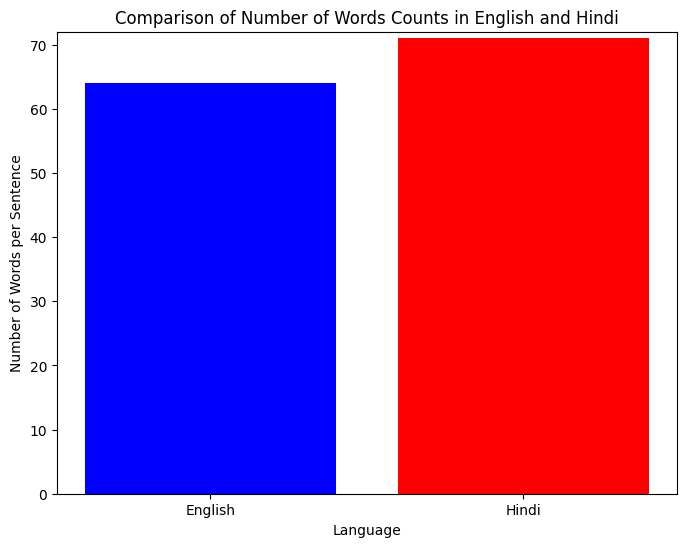

In [13]:
# Calculate averages
average_english_words = df_clean['English_Words'].quantile(.99)
average_hindi_words = df_clean['Hindi_Words'].quantile(.99)

# Data for plotting
averages = [average_english_words, average_hindi_words]
languages = ['English', 'Hindi']

# Creating the plot
plt.figure(figsize=(8, 6))
plt.bar(languages, averages, color=['blue', 'red'])
plt.xlabel('Language')
plt.ylabel('Number of Words per Sentence')
plt.title('Comparison of Number of Words Counts in English and Hindi')
plt.ylim(0, max(averages) + 1)  # Adjust y-axis for better visualization
plt.show()

# Torchtext
Torchtext is a library within the PyTorch ecosystem designed to facilitate the preprocessing of textual data.

## get_tokenizer
. The get_tokenizer function is one of the core utilities provided by torchtext for tokenizing text data.

. get_tokenizer retrieves a tokenizer function based on the method specified. This tokenizer can then be used to convert strings of text into lists of tokens.
##Parameters
  
  tokenizer: This argument specifies the type of tokenizer to use. You can specify built-in tokenizers such as "basic_english", "spacy", "moses", or even provide a custom tokenizer function.

  language: Some tokenizers, like those based on the Moses or Spacy libraries, might require you to specify the language of the text, which influences how the text is tokenized (e.g., handling language-specific punctuation and splitting rules).

In [14]:
tokenizer_eng = get_tokenizer('basic_english')
tokenizer_hin = indic_tokenize.trivial_tokenize  # This is the Hindi tokenizer from Indic NLP

tokenized_english_txt = [tokenizer_eng(english_sen) for english_sen in df_clean['english_txt'] ]
tokenized_hindi_txt = [tokenizer_hin(hindi_sen) for hindi_sen in df_clean['hindi_txt'] ]

In [15]:
print(tokenized_english_txt[9])
print(tokenized_hindi_txt[9])

['the', 'path', 'of', 'those', 'you', 'have', 'blessed', 'not', 'of', 'those', 'who', 'have', 'earned', 'your', 'anger', 'nor', 'those', 'who', 'have', 'gone', 'astray']
['उन', 'लग', 'क', 'मरग', 'पर', 'ज', 'तर', 'कपपतर', 'हए', 'ज', 'न', 'परकप', 'क', 'भग', 'हए', 'और', 'न', 'पथभरषट']


## build_vocab_from_iterator
`build_vocab_from_iterator` function in the torchtext.vocab module is used to create a vocabulary from an iterable of tokenized data. This vocabulary is essential for converting textual data into numerical form.

#Parameters:
##tokenized_conv (iterator):
This is the main data input to the function. It should be an iterator (like a `generator` or a `list`) that yields sequences of tokens. Each sequence represents a document or an example in your dataset.
##min_freq (int, optional):
 This parameter specifies the minimum frequency a token must have to be included in the vocabulary. Tokens that appear fewer than min_freq times are excluded from the vocabulary. This is useful for removing rare words which might be typos or irrelevant to most analyses.
##specials (list of str, optional):
 This is a list of special tokens that you want to add to the vocabulary. Common special tokens include:
'<pad>': A padding token used to equalize the lengths of sequences.
'<oov>' (or '<unk>' for "unknown"): A token used to represent out-of-vocabulary words during inference, or when a word appears that is not in the training vocabulary.
##special_first (bool, optional):
 Determines the ordering of special tokens in the vocabulary. If True, special tokens are added at the beginning of the vocabulary. This can be helpful for certain models where token indices are significant (e.g., models using embedding layers might have specific handling for lower indices).

In [17]:
import torchtext
from torchtext.vocab import build_vocab_from_iterator
# Step 3: Building Vocabulary
features_vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_english_txt, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
target_vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_hindi_txt, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

features_vocab.set_default_index(features_vocab['<unk>'])
target_vocab.set_default_index(target_vocab['<unk>'])

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [18]:
features_vocab_total_words = len(features_vocab)
target_vocab_total_words = len(target_vocab)

In [19]:
print(features_vocab_total_words)  #English
print(target_vocab_total_words)    #Hindi

6544
4083


In [20]:
features_vocab['<bos>']

2

In [21]:
print(features_vocab_total_words)
print(target_vocab_total_words)

6544
4083


In [22]:
def tokens_to_indices(tokenized_texts, vocab):
    indices_texts = []
    for sentence in tokenized_texts:
        indices_texts.append([vocab[token] for token in sentence if token in vocab])
    return indices_texts

In [23]:
english_indices = tokens_to_indices(tokenized_english_txt, features_vocab)
hindi_indices = tokens_to_indices(tokenized_hindi_txt, target_vocab)

In [24]:
english_indices[0:5]

[[5057, 4617],
 [4617, 8, 3848, 8],
 [3848, 192, 11, 5764],
 [11, 4, 349, 6, 24, 72, 1376, 197, 173],
 [36, 329, 27, 8, 24, 38, 6, 36, 4, 561]]

In [25]:
class TranslationDataset(Dataset):
    def __init__(self, english_data, hindi_data):
        self.english_data = english_data
        self.hindi_data = hindi_data

    def __len__(self):
        return len(self.english_data)

    def __getitem__(self, idx):
        english = torch.tensor(self.english_data[idx], dtype=torch.long)
        hindi = torch.tensor(self.hindi_data[idx], dtype=torch.long)
        return english, hindi

# Create the custom dataset
dataset = TranslationDataset(english_indices, hindi_indices)
FIXED_LENGTH = 60  # or any appropriate length based on your data or model requirements


##Purpose of collate_fn
The primary purpose of `collate_fn` is to dynamically decide how to combine multiple data samples into a single batch. Data samples can be anything from images, texts, or other forms of data, and they might not naturally fit together in a straightforward way (e.g., texts of varying lengths).

In [26]:
def collate_batch(batch):
    english_batch, hindi_batch = zip(*batch)

    # Pad or truncate English batch
    english_batch = [torch.tensor(seq[:FIXED_LENGTH], dtype=torch.long) if len(seq) > FIXED_LENGTH else torch.cat([torch.tensor(seq, dtype=torch.long), torch.full((FIXED_LENGTH - len(seq),), features_vocab['<pad>'], dtype=torch.long)]) for seq in english_batch]

    # Pad or truncate Hindi batch
    hindi_batch = [torch.tensor(seq[:FIXED_LENGTH], dtype=torch.long) if len(seq) > FIXED_LENGTH else torch.cat([torch.tensor(seq, dtype=torch.long), torch.full((FIXED_LENGTH - len(seq),), target_vocab['<pad>'], dtype=torch.long)]) for seq in hindi_batch]

    # Convert lists to tensors
    english_batch = torch.stack(english_batch)
    hindi_batch = torch.stack(hindi_batch)

    return english_batch, hindi_batch


In [27]:
batch_size = 32  # Adjust the batch size as needed
train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_batch, shuffle=True)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
print(device)

cuda


In [30]:
sample = next(iter(train_dataloader))

<ipython-input-26-6d92b6dff899>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  english_batch = [torch.tensor(seq[:FIXED_LENGTH], dtype=torch.long) if len(seq) > FIXED_LENGTH else torch.cat([torch.tensor(seq, dtype=torch.long), torch.full((FIXED_LENGTH - len(seq),), features_vocab['<pad>'], dtype=torch.long)]) for seq in english_batch]
<ipython-input-26-6d92b6dff899>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hindi_batch = [torch.tensor(seq[:FIXED_LENGTH], dtype=torch.long) if len(seq) > FIXED_LENGTH else torch.cat([torch.tensor(seq, dtype=torch.long), torch.full((FIXED_LENGTH - len(seq),), target_vocab['<pad>'], dtype=torch.long)]) for seq in hindi_batch]


In [31]:
sample[0].size()

torch.Size([32, 60])

`get_itos`: stands for "index-to-string". The method returns a list where the indices in the list correspond to the numerical indices used in your model, and the values at those indices are the actual string representations (tokens).

In [32]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):    #[4,8,9,15,12]
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [33]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()

        self.Wa = nn.Linear(hidden_size, hidden_size)   # Transform for query
        self.Ua = nn.Linear(hidden_size, hidden_size)   # Transform for keys
        self.Va = nn.Linear(hidden_size, 1)   # Compute the attention score

    def forward(self, query, keys):
        # Expand query to match keys' batch and sequence dimension
        # Encoder Output i.e key Shape (batch, seq_len, hidden_dim) when batch_first = True
        # Hidden State of Decoder i.e query shape (num_dir*num_layers, batch, hidden_dim)

        # Since Decoder Queries about the information to encoder on which token to focus when generating the current token
        # we need to replecate the decoder Hidden State along the encoder output to get score for each output.
        key_shape = keys.size()

        query = query.repeat(1, key_shape[1], 1)
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))  # attn_score = VT.(tanh(Wa*s|encoder + Ua|decoder + bias))
        scores = scores.squeeze(-1)

        weights = torch.softmax(scores, dim=1)
        weights = weights.unsqueeze(1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)

        bos_token_index = features_vocab['<bos>']
        decoder_input = torch.full((batch_size, 1), bos_token_index, dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []
        # fixed length set to 60
        for i in range(60):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)    # this is the shape of [num_layers * num_directions, batch_size, hidden_size]
                                            # encoder output [batch_size, seq_len, hidden_size]
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [34]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [36]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=5, plot_every=5, save_every=5, save_path = "/content/drive/MyDrive/parallel-n"):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

        if epoch % save_every == 0:
            encoder_save_path = os.path.join(save_path, f'/content/drive/MyDrive/parallel-n/encoder_epoch_{epoch}.pth')
            decoder_save_path = os.path.join(save_path, f'/content/drive/MyDrive/parallel-n/decoder_epoch_{epoch}.pth')
            torch.save(encoder.state_dict(), encoder_save_path)
            torch.save(decoder.state_dict(), decoder_save_path)
            print(f'Model saved at epoch {epoch}')
    showPlot(plot_losses)

In [37]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [38]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [39]:
hidden_size = 128
batch_size = 32
features_vocab_total_words = len(features_vocab)
target_vocab_total_words = len(target_vocab)

encoder = EncoderRNN(features_vocab_total_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, target_vocab_total_words).to(device)

In [40]:
train(train_dataloader, encoder, decoder, n_epochs = 50, print_every=5, plot_every=5)

<ipython-input-26-6d92b6dff899>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  english_batch = [torch.tensor(seq[:FIXED_LENGTH], dtype=torch.long) if len(seq) > FIXED_LENGTH else torch.cat([torch.tensor(seq, dtype=torch.long), torch.full((FIXED_LENGTH - len(seq),), features_vocab['<pad>'], dtype=torch.long)]) for seq in english_batch]
<ipython-input-26-6d92b6dff899>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hindi_batch = [torch.tensor(seq[:FIXED_LENGTH], dtype=torch.long) if len(seq) > FIXED_LENGTH else torch.cat([torch.tensor(seq, dtype=torch.long), torch.full((FIXED_LENGTH - len(seq),), target_vocab['<pad>'], dtype=torch.long)]) for seq in hindi_batch]


3m 15s (- 29m 15s) (5 10%) 1.6450
Model saved at epoch 5
6m 26s (- 25m 46s) (10 20%) 1.1560
Model saved at epoch 10
9m 38s (- 22m 28s) (15 30%) 0.9235
Model saved at epoch 15
12m 48s (- 19m 12s) (20 40%) 0.7790
Model saved at epoch 20
16m 0s (- 16m 0s) (25 50%) 0.6810
Model saved at epoch 25
19m 11s (- 12m 47s) (30 60%) 0.6085
Model saved at epoch 30
22m 22s (- 9m 35s) (35 70%) 0.5532
Model saved at epoch 35
25m 31s (- 6m 22s) (40 80%) 0.5076
Model saved at epoch 40
28m 41s (- 3m 11s) (45 90%) 0.4698
Model saved at epoch 45
31m 52s (- 0m 0s) (50 100%) 0.4379
Model saved at epoch 50


In [41]:
encoder.load_state_dict(torch.load("/content/drive/MyDrive/parallel-n/encoder_epoch_50.pth"))
decoder.load_state_dict(torch.load("/content/drive/MyDrive/parallel-n/decoder_epoch_50.pth"))

<All keys matched successfully>

In [42]:
def evaluate(encoder, decoder, sentence, feature_vocab, target_vocab):
    with torch.no_grad():

        tokenized_english_txt_test = tokenizer_eng(sentence)
        english_indices_test = tokens_to_indices(tokenized_english_txt_test, features_vocab)
        input_tensor = torch.LongTensor(english_indices_test).to(device).reshape(1,4)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        EOS_token = feature_vocab['<eos>']
        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<eos>')
                break
            decoded_words.append(target_vocab.get_itos()[idx] if idx < len(target_vocab) else '<unk>')
    return decoded_words, decoder_attn

In [43]:
sentence = "Hi How are you"
decoder_output, attn_weights = evaluate(encoder, decoder, sentence, features_vocab, target_vocab)

In [44]:
def indices_to_words(indices, vocab):
  return [vocab.get_itos()[index] if index < len(vocab) else '<unk>' for index in indices]